In [57]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout , Dense ,Flatten , Input
import tensorflow as tf

In [38]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical


In [39]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

In [40]:
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [41]:
inital_learning_rate = 0.0001
epoch = 20
batch_size = 32

In [42]:
DIRECTORY = r"dataset"
CATEGORIES = ['with_mask','without_mask']

In [43]:
data = []
labels = []

In [44]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        data.append(image)
        labels.append(category)

In [46]:
lb = LabelBinarizer()
labels=lb.fit_transform(labels)
labels = to_categorical(labels)

In [47]:
data = np.array(data,dtype='float32')
labels = np.array(labels)

In [48]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

In [49]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,horizontal_flip=True,
fill_mode="nearest")

In [50]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

9412608/9406464 [==============================] - 28s 3us/step


In [51]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [58]:
model = tf.keras.Model(inputs=baseModel.input, outputs=headModel)


In [60]:
for layer in baseModel.layers:
    layer.trainable = False

In [61]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=inital_learning_rate,decay=inital_learning_rate/epoch)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

[INFO] compiling model...


In [63]:
print("[INFO] training head...")
H = model.fit(aug.flow(trainX, trainY, batch_size=batch_size),
steps_per_epoch=len(trainX) // batch_size,
validation_data=(testX, testY),
validation_steps=len(testX) // batch_size,
epochs=epoch)


[INFO] training head...
Epoch 1/20
95/95 [==============================] - 235s 2s/step - loss: 0.5668 - accuracy: 0.7403 - val_loss: 0.1547 - val_accuracy: 0.9700
Epoch 2/20
95/95 [==============================] - 270s 3s/step - loss: 0.1644 - accuracy: 0.9551 - val_loss: 0.0888 - val_accuracy: 0.9791
Epoch 3/20
95/95 [==============================] - 304s 3s/step - loss: 0.1070 - accuracy: 0.9739 - val_loss: 0.0707 - val_accuracy: 0.9817
Epoch 4/20
95/95 [==============================] - 241s 3s/step - loss: 0.0863 - accuracy: 0.9783 - val_loss: 0.0572 - val_accuracy: 0.9817
Epoch 5/20
95/95 [==============================] - 247s 3s/step - loss: 0.0686 - accuracy: 0.9814 - val_loss: 0.0516 - val_accuracy: 0.9844
Epoch 6/20
95/95 [==============================] - 259s 3s/step - loss: 0.0566 - accuracy: 0.9842 - val_loss: 0.0483 - val_accuracy: 0.9857
Epoch 7/20
95/95 [==============================] - 257s 3s/step - loss: 0.0475 - accuracy: 0.9864 - val_loss: 0.0469 - val_accura

In [65]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=batch_size)

[INFO] evaluating network...


In [66]:
predIdxs = np.argmax(predIdxs, axis=1)


In [68]:
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] saving mask detector model...


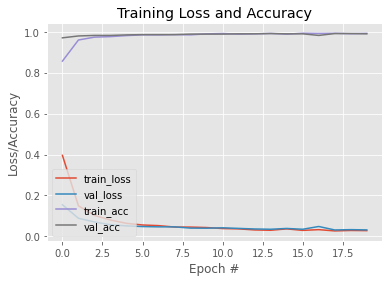

In [69]:
N = epoch
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")